In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn  
import torch.optim as optim  
import torchvision.transforms as transforms 
import torchvision
import os
from skimage import io
from torch.utils.data import (Dataset,DataLoader) 

In [2]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
main_directory = '/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/training-c.csv'
df = pd.read_csv(main_directory, sep=",")
print(df)

         filename           original filename  ...  contributing team  database name
0      c00000.png  Scan_280_digit_6_num_7.png  ...   Buet_Backpropers     training-c
1      c00001.png   Scan_29_digit_1_num_1.png  ...   Buet_Backpropers     training-c
2      c00002.png  Scan_131_digit_3_num_1.png  ...   Buet_Backpropers     training-c
3      c00003.png  Scan_160_digit_2_num_2.png  ...   Buet_Backpropers     training-c
4      c00004.png  Scan_202_digit_7_num_0.png  ...   Buet_Backpropers     training-c
...           ...                         ...  ...                ...            ...
24293  c24293.png  Scan_167_digit_3_num_4.png  ...   Buet_Backpropers     training-c
24294  c24294.png  Scan_174_digit_2_num_8.png  ...   Buet_Backpropers     training-c
24295  c24295.png  Scan_152_digit_7_num_4.png  ...   Buet_Backpropers     training-c
24296  c24296.png  Scan_123_digit_2_num_2.png  ...   Buet_Backpropers     training-c
24297  c24297.png    Scan_2_digit_7_num_6.png  ...   Buet_Backpro

In [5]:
df.columns

Index(['filename', 'original filename', 'scanid', 'digit',
       'database name original', 'contributing team', 'database name'],
      dtype='object')

In [6]:
df = df.drop(['original filename','scanid','database name original', 'contributing team','database name'], axis = 1)

In [7]:
df.to_csv('/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/modified.csv',index = False)

In [8]:
batch_size = 25
num_iters = 20000
input_dim = 100*100 
output_dim = 10
learning_rate = 0.001 


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
class HandWrittenNumberRecognition(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)

        return (image, y_label)

In [10]:
transform_Img = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Grayscale(num_output_channels=1),
                                    transforms.Resize(100),
                                    transforms.ToTensor()])

In [11]:
dataset = HandWrittenNumberRecognition(
    csv_file="/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/modified.csv",
    root_dir="/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/training-c",
    transform=transform_Img
)

In [12]:
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [19438,4860])
print(len(train_dataset))
print(len(test_dataset))

19438
4860


In [13]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)  

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)  

In [14]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
      
        self.linear_1 = nn.Linear(input_size,350)
        self.tanh_1 = nn.Tanh()

        self.linear_2 = nn.Linear(350, 300)
        self.relu_1   =  nn.ReLU()

        self.linear_3 = nn.Linear(300, 250)
        self.tanh_2 =  nn.Tanh()

        self.linear_4 = nn.Linear(250, 200)
        self.relu_2   =  nn.ReLU()

        self.linear_5 = nn.Linear(200, 150)
        self.tanh_3 =  nn.Tanh()

        self.linear_out = nn.Linear(150, num_classes)

    def forward(self, x):
       
        out  = self.linear_1(x)
        out =  self.tanh_1(out)
        
        out  = self.linear_2(out)
        out =  self.relu_1(out)

        out  = self.linear_3(out)
        out =  self.tanh_2(out)

        out  = self.linear_4(out)
        out =  self.relu_2(out)

        out  = self.linear_5(out)
        out =  self.tanh_3(out)
        
        probas  = self.linear_out(out)
        return probas



model = DeepNeuralNetworkModel(input_size = input_dim,
                               num_classes = output_dim)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.7)

In [15]:
num_epochs = num_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)
print(num_epochs)


25


In [16]:
iter = 0
total_loss = []
iteration = []
correctly_classified_PerEpoch = []
accuracy_perEpoch = []
num_of_epoch = []
for epoch in range(num_epochs):
    print('Epoch: ',epoch+1)
    num_of_epoch.append(epoch+1)
    for i, (images, labels) in enumerate(train_loader):

        images = images.view(-1, 100*100).to(device)

        labels = labels.to(device)

        # Clear gradients w.r.t. parameters
        optimizer.zero_grad()

        # Forward pass to get output/logits
        outputs = model(images) 

        # Calculate Loss: softmax --> cross entropy loss
        loss = criterion(outputs, labels)

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()

        iter += 1
        print('Iteration no: ',iter)
        if iter % 1000 == 0:
            print('loss in iteration ',iter,'= ',loss.item())
            total_loss.append(loss.item())
            iteration.append(iter)

    correct = 0
    total = 0
    for images, labels in test_loader:
          
          images = images.view(-1,100*100).to(device)
          outputs = model(images)
 
          _, predicted = torch.max(outputs, 1)

          total += labels.size(0)
 
          if torch.cuda.is_available():
                correct += (predicted.cpu() == labels.cpu()).sum() 
          else:
                correct += (predicted == labels).sum()

    accuracy = 100 * correct.item() / total
    accuracy_perEpoch.append(accuracy)
    correctly_classified_PerEpoch.append(correct.item())
    print('Total Data: {}.  CorrectlyPredicted: {}.'.format(total,correct))
    print('Accuracy in epoch ',epoch+1,'=',accuracy)

Streaming output truncated to the last 5000 lines.
Iteration no:  14476
Iteration no:  14477
Iteration no:  14478
Iteration no:  14479
Iteration no:  14480
Iteration no:  14481
Iteration no:  14482
Iteration no:  14483
Iteration no:  14484
Iteration no:  14485
Iteration no:  14486
Iteration no:  14487
Iteration no:  14488
Iteration no:  14489
Iteration no:  14490
Iteration no:  14491
Iteration no:  14492
Iteration no:  14493
Iteration no:  14494
Iteration no:  14495
Iteration no:  14496
Iteration no:  14497
Iteration no:  14498
Iteration no:  14499
Iteration no:  14500
Iteration no:  14501
Iteration no:  14502
Iteration no:  14503
Iteration no:  14504
Iteration no:  14505
Iteration no:  14506
Iteration no:  14507
Iteration no:  14508
Iteration no:  14509
Iteration no:  14510
Iteration no:  14511
Iteration no:  14512
Iteration no:  14513
Iteration no:  14514
Iteration no:  14515
Iteration no:  14516
Iteration no:  14517
Iteration no:  14518
Iteration no:  14519
Iteration no:  14520
Iter

In [17]:
root_path = '/content/drive/MyDrive/SOFT COMPUTING/ASSIGNMENT2/Experiment_02_03/ALLCOVERED'
save_model = True

if save_model is True:
    torch.save(model.state_dict(), root_path + '170104027_Exp2_3.pkl') 

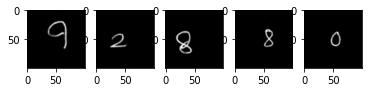

In [18]:
import matplotlib
for images, labels in test_loader:
    break
fig, ax = plt.subplots(1, 5)
for i in range(5):
    ax[i].imshow(images[i].view(100,100), cmap=matplotlib.cm.binary)

plt.show()

In [19]:
for images, labels in test_loader:
    break
for i in range(11,18):
   predictions = model(images[i].view(-1, 100*100).to(device))
   predictions = torch.argmax(predictions, dim=1)
   print('Predicted labels', predictions.cpu().numpy())
   print(predictions)
   print(labels[i])

Predicted labels [0]
tensor([0], device='cuda:0')
tensor(9)
Predicted labels [9]
tensor([9], device='cuda:0')
tensor(2)
Predicted labels [8]
tensor([8], device='cuda:0')
tensor(2)
Predicted labels [8]
tensor([8], device='cuda:0')
tensor(7)
Predicted labels [7]
tensor([7], device='cuda:0')
tensor(4)
Predicted labels [8]
tensor([8], device='cuda:0')
tensor(8)
Predicted labels [0]
tensor([0], device='cuda:0')
tensor(6)


In [20]:
print('loss count after every 750 iteration: ',total_loss)
print('iteration count: ',iteration)
print('Correctly classfied per epoch: ',correctly_classified_PerEpoch)
print('accuracy per epoch: ',accuracy_perEpoch)
print('Epoch list: ',num_of_epoch)

loss count after every 750 iteration:  [2.2962441444396973, 2.3047916889190674, 2.3014752864837646, 2.3063008785247803, 2.3131155967712402, 2.29949688911438, 2.303940534591675, 2.2977194786071777, 2.2921648025512695, 2.3067917823791504, 2.3085484504699707, 2.2883074283599854, 2.2976973056793213, 2.2773094177246094, 2.2884373664855957, 2.2463176250457764, 2.1532280445098877, 2.0913829803466797, 2.3712000846862793]
iteration count:  [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000]
Correctly classfied per epoch:  [469, 469, 596, 469, 487, 474, 505, 507, 662, 469, 470, 493, 623, 739, 500, 794, 752, 921, 894, 522, 718, 626, 693, 709, 1102]
accuracy per epoch:  [9.650205761316872, 9.650205761316872, 12.263374485596708, 9.650205761316872, 10.020576131687243, 9.753086419753087, 10.390946502057613, 10.432098765432098, 13.621399176954732, 9.650205761316872, 9.670781893004115, 10.1440329218107, 12.818930041152264, 15.2057

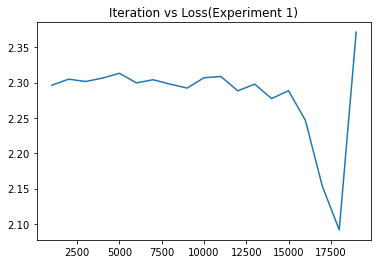

In [21]:
plt.plot(iteration,total_loss)
plt.title('Iteration vs Loss(Experiment 1)')
plt.show()

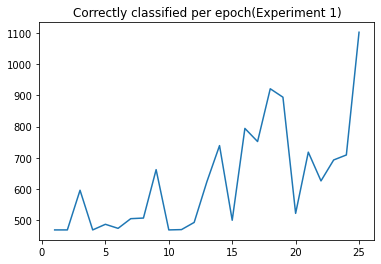

In [22]:
plt.plot(num_of_epoch,correctly_classified_PerEpoch)
plt.title('Correctly classified per epoch(Experiment 1)')
plt.show()

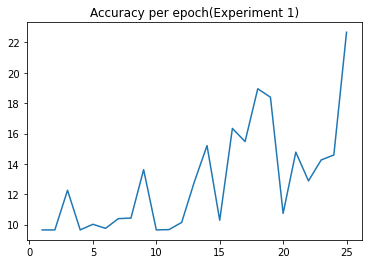

In [23]:
plt.plot(num_of_epoch,accuracy_perEpoch)
plt.title('Accuracy per epoch(Experiment 1)')
plt.show()